In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pickle

pd.set_option("display.max_columns", None)

def run_report(start, end):
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    market_cap = pd.read_csv('input/market_cap.csv')

    # Melt the DataFrame to have a long format with Date, Ticker, and Market Cap
    firm_market_caps = market_cap.melt(id_vars=['Date'], var_name='Ticker', value_name='firm_date_market_cap')
    firm_market_caps['Date'] = pd.to_datetime(firm_market_caps['Date'])

    # Read the ray data
    ray_df = pd.read_excel('input/RAY as of OCT 23 20231_PA.xlsx')
    ray_df = ray_df.sort_values('Market Cap\n', ascending=False)

    # Clean the columns and ticker values
    ray_df.columns = ray_df.columns.str.rstrip('\n')
    ray_df['Ticker'] = ray_df['Ticker'].str.split(' ', n=1, expand=True)[0].replace(' ', '')

    # Filter relevant columns and rows
    ray_df = ray_df[['Ticker', 'GICS Sector']].head(100)

    # Merge the DataFrames
    report_df = pd.merge(firm_market_caps, ray_df, on='Ticker')

    # Filter by date range and sort the DataFrame
    report_df = report_df[(report_df['Date'] >= start_date) & (report_df['Date'] <= end_date)]
    report_df = report_df.sort_values('Date')

    # Group by Date and GICS Sector and sum the market caps
    report_df = report_df.groupby(['Date', 'GICS Sector'])['firm_date_market_cap'].sum().reset_index()
    report_df.columns = ['Date', 'GICS Sector', 'Market Cap']

    # Calculate the returns
    report_df['Return'] = report_df.groupby('GICS Sector')['Market Cap'].transform(lambda x: ((x / x.iloc[0]) - 1) * 100)

    # Calculate the total market cap per date
    total_market_cap = report_df.groupby('Date')['Market Cap'].sum().reset_index()
    total_market_cap.columns = ['Date', 'Total Market Cap']

    # Merge the total market cap with the report DataFrame
    report_df = pd.merge(report_df, total_market_cap, on='Date')

    run_report.report = report_df

    # Calculate the index return
    run_report.index_return = (((report_df.iloc[-1]['Total Market Cap'] / report_df.iloc[0]['Total Market Cap']) - 1) * 100)














    input_file_path = os.path.join(os.getcwd(), "input/date_dataframes.pkl")

    with open(input_file_path, 'rb') as input_file:
        date_dataframes = pickle.load(input_file)

    df = pd.read_excel('input/RAY as of OCT 23 20231_PA.xlsx')
    df = df.sort_values('Market Cap\n',ascending=False)  
    df.columns = df.columns.str.rstrip('\n')
    df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
    float_df = df[['Ticker','Equity Float']].head(100)
    float_df

    eod_market_cap_pivot_close = pd.DataFrame()
    eod_market_cap_pivot_mktcap = pd.DataFrame()

    for date in list(date_dataframes.keys()):
        if date >= start and date <= end:
            eod_df = date_dataframes[date]

            merged_df = pd.merge(float_df,eod_df,left_on='Ticker',right_on='underlying_symbol')

            merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']
    
            eod_market_cap_daily_close = merged_df.pivot_table(values='close',index='quote_date',columns='Ticker',aggfunc='sum')

            eod_market_cap_daily_mktcap = merged_df.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')
    
            eod_market_cap_pivot_close = pd.concat([eod_market_cap_pivot_close,eod_market_cap_daily_close])

            eod_market_cap_pivot_mktcap = pd.concat([eod_market_cap_pivot_mktcap,eod_market_cap_daily_mktcap])

    eod_market_cap_pivot_close = eod_market_cap_pivot_close.rename_axis(index='Date')
    eod_market_cap_pivot_close.index = pd.to_datetime(eod_market_cap_pivot_close.index,errors='coerce')

    eod_market_cap_pivot_mktcap = eod_market_cap_pivot_mktcap.rename_axis(index='Date')
    eod_market_cap_pivot_mktcap.index = pd.to_datetime(eod_market_cap_pivot_mktcap.index,errors='coerce')


    run_report.eod_market_cap_pivot_close = eod_market_cap_pivot_close
    run_report.eod_market_cap_pivot_mktcap = eod_market_cap_pivot_mktcap







    from collections import defaultdict

    # Initialize a dictionary to hold lists of tickers for each GICS sector
    gics_sector_dict = defaultdict(list)

    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        gics_sector = row['GICS Sector']
        ticker = row['Ticker']
        gics_sector_dict[gics_sector].append(ticker)

    # Convert defaultdict to a regular dict (optional)
    gics_sector_dict = dict(gics_sector_dict)






    total_market_cappp = eod_market_cap_pivot_mktcap.sum(axis=1)[0]

    stock_price_data = {}
    sector_weight = {}

    for sector in gics_sector_dict.keys():
        info = []
        marketcap = 0
        for ticker in eod_market_cap_pivot_close.keys():
            if ticker in gics_sector_dict[sector]:
                ret = ((((eod_market_cap_pivot_close.at[eod_market_cap_pivot_close.index[-1],ticker]) / (eod_market_cap_pivot_close.at[eod_market_cap_pivot_close.index[0],ticker])) -1 ) * 100)
                mktcap = eod_market_cap_pivot_mktcap.at[eod_market_cap_pivot_mktcap.index[0],ticker]
                info.append({'Ticker': ticker, 'Return': ret, 'MktCap': mktcap})

                marketcap += mktcap

        stock_price = pd.DataFrame(info)

        total_weight = stock_price['MktCap'].sum()
        stock_price['LocalWeight'] = round((stock_price['MktCap'] / total_weight),6)*100
        stock_price['Weight'] = round((stock_price['MktCap'] / report_df['Total Market Cap'].head(1).values[0]),6)*100
        stock_price['RelativeReturn'] = round((stock_price['Return'] * (stock_price['LocalWeight'] / 100)),6)

        stock_price_data[sector] = stock_price

        weight = marketcap / total_market_cappp

        sector_weight[sector] = weight


    sec = pd.DataFrame(sector_weight,index=sector_weight.values()).iloc[0].to_frame().reset_index()
    sec.columns = ['GICS Sector','Weight']
    sec = sec.sort_values('Weight',ascending=False).reset_index().drop(columns='index')
    run_report.sector_weight = sec
    run_report.stock_price_data = stock_price_data

    run_report.final_day_values = report_df.iloc[-11:]














    max_return = report_df.iloc[-11:]['Return'].max()
    min_return = report_df.iloc[-11:]['Return'].min()


    for i,ret in enumerate(report_df.iloc[-11:]['Return']):
        if ret == max_return:
            max_gics_sector = report_df.iloc[i]['GICS Sector']
            max = stock_price_data[max_gics_sector]
        if ret == min_return:
            min_gics_sector = report_df.iloc[i]['GICS Sector']
            min = stock_price_data[min_gics_sector]

    max_rel_return = max['RelativeReturn'].max()
    min_rel_return = min['RelativeReturn'].min()

    for i,rel_ret in enumerate(max['RelativeReturn']):
        if rel_ret == max_rel_return:
            max_ticker = max.iloc[i]['Ticker']
            max_ticker_return = max.iloc[i]['Return']
            max_ticker_localweight = max.iloc[i]['LocalWeight']
            max_ticker_weight = max.iloc[i]['Weight']

    for i,rel_ret in enumerate(min['RelativeReturn']):
        if rel_ret == min_rel_return:
            min_ticker = min.iloc[i]['Ticker']
            min_ticker_return = min.iloc[i]['Return']
            min_ticker_localweight = min.iloc[i]['LocalWeight']
            min_ticker_weight = min.iloc[i]['Weight']

    statement = (f"The highest performing sector during this period was the {max_gics_sector} sector, with a return of {round(max_return,2)}%. This was primarily led by {max_ticker}\
, whose stock returned {round(max_ticker_return,2)}%. {max_ticker} makes up {round(max_ticker_localweight,2)}% of the {max_gics_sector} sector and {round(max_ticker_weight,2)}% of the entire index. \
The lowest performing sector during this period was the {min_gics_sector} sector, with a return of {round(min_return,2)}%. This was primarily led by {min_ticker}\
, whose stock returned {round(min_ticker_return,2)}%. {min_ticker} makes up {round(min_ticker_localweight,2)}% of the {min_gics_sector} sector and {round(min_ticker_weight,2)}% of the entire index.")

    run_report.statement = statement
    run_report.best_sector = max
    run_report.worst_sector = min















    
    def make_returns_over_time(report):
        def create_returns_over_time():
            plt.figure(figsize=(12, 8))

            # Loop through each sector and plot the data
            for sector in report['GICS Sector'].unique():
                sector_data = report[report['GICS Sector'] == sector]
                plt.plot(sector_data['Date'], sector_data['Return'], label=sector)

            # Set major formatter for dates to display only date part
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

            # Set major locator to display only unique dates
            unique_dates = report['Date'].unique()
            plt.gca().set_xticks(unique_dates)

            # Add labels, title, and legend
            plt.xlabel('Date')
            plt.ylabel('Return')
            plt.title('Returns Over Time by Sector')
            plt.legend(title='GICS Sector')

            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45, ha='right')

            # Adjust layout for better fit
            plt.tight_layout()

            # Show the plot
            plt.show()

        return create_returns_over_time

    ret_over_time = make_returns_over_time(report_df)








    def make_pie_chart(sector_weight):
        def create_pie_chart():
            # Create the pie chart
            labels = list(sector_weight.keys())
            sizes = list(sector_weight.values())

            # Define a new color palette
            pastel_colors = [
            '#FFB3BA',
            '#FFDFBA',
            '#FFFFBA',
            '#BAFFC9',
            '#BAE1FF',
            '#CBAACB',
            '#FFDAC1',
            '#B5EAD7',
            '#E2F0CB',
            '#C6DBDA',
            '#F3C4FB'
            ]

            # Custom function to format labels
            def autopct_format(values):
                def my_format(pct):
                    return ('%.1f%%' % pct) if pct > 4 else ''
                return my_format

            fig, ax = plt.subplots()
            ax.pie(sizes, labels=labels, autopct=autopct_format(sizes), startangle=140, colors=pastel_colors)
            ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

            # Display the pie chart
            plt.title("Sector Weights")
            plt.show()
            plt.close()
    
        return create_pie_chart

    # Assign the function to a variable
    seccy_weight = make_pie_chart(sector_weight)

    # Call the variable to display the pie chart



    def make_bar_chart(dataframe):
        def create_bar_chart():


            df = dataframe.iloc[-11:][['GICS Sector','Return']]

            # Sort the DataFrame by 'GICS Sector' in descending alphabetical order
            df = df.sort_values(by='GICS Sector', ascending=False)

            # Plotting the bar chart
            plt.figure(figsize=(10, 6))
            colors = ['green' if x > 0 else 'red' for x in df['Return']]
            bars = plt.barh(df['GICS Sector'], df['Return'], color=colors)

            # Adding values to the ends of the bars
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.10 if width > 0 else width - 0.10, 
                         bar.get_y() + bar.get_height() / 2, 
                         f'{width:.2f}%', 
                         ha='left' if width > 0 else 'right', 
                         va='center', 
                         color='black')

            # Setting x-axis limits
            plt.xlim(-6, 4)

            # Removing the border
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)

            # Labels and title
            plt.xlabel('Return (%)')
            plt.ylabel('GICS Sector')
            plt.title('Index Return')
            plt.grid(axis='x', linestyle='--', alpha=0.7)

            # Adjust the margins to make space for the labels
            plt.subplots_adjust(left=0.25)

            plt.show()
            plt.close()
        return create_bar_chart
    thebarchart = make_bar_chart(report_df)



    

    


    
    return ret_over_time(),seccy_weight(),thebarchart()

C:\Users\micha\AppData\Local\Temp\ipykernel_17040\2033711467.py:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_market_cappp = eod_market_cap_pivot_mktcap.sum(axis=1)[0]


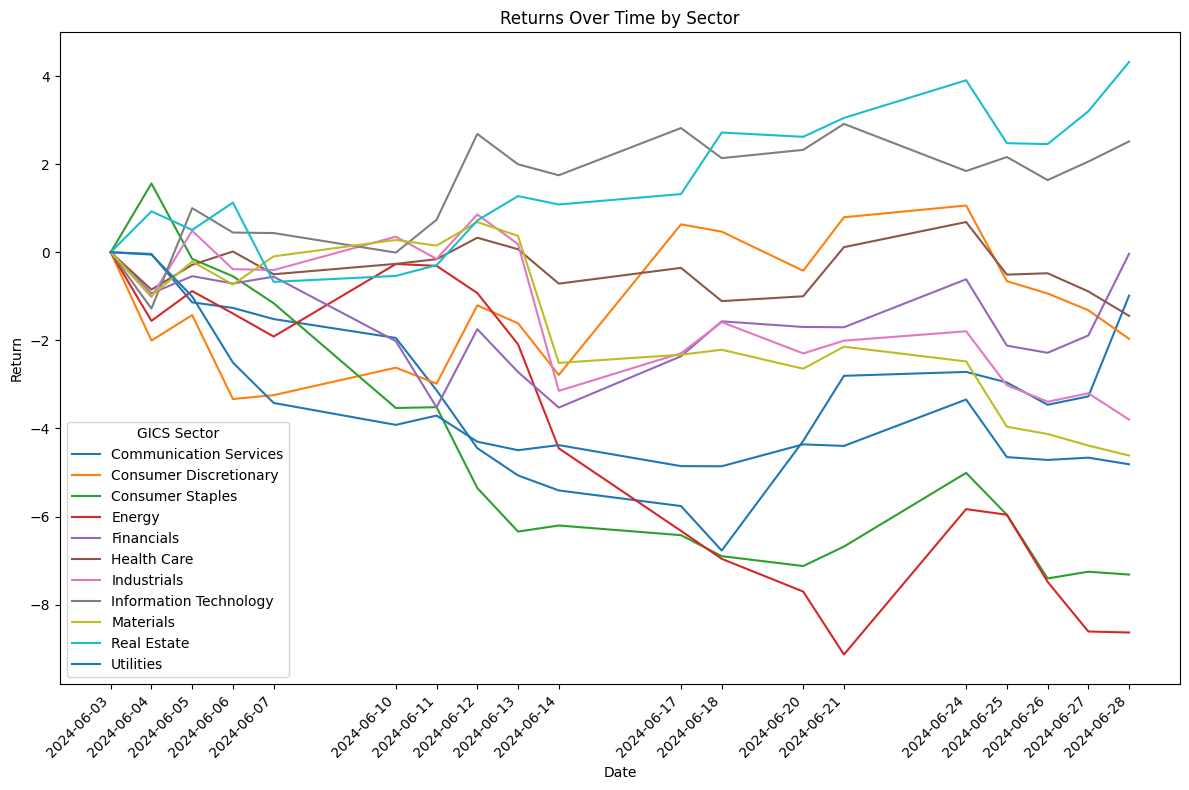

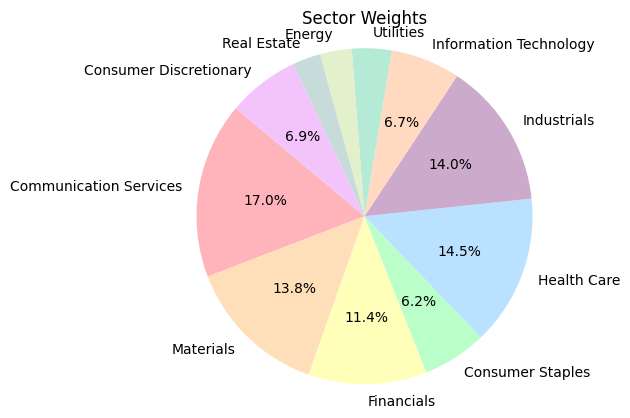

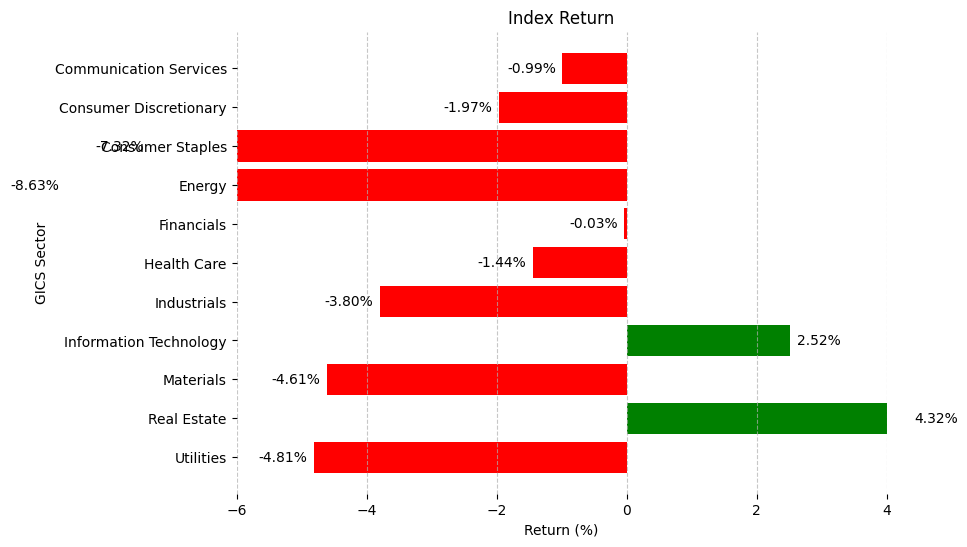

(None, None, None)

In [2]:
run_report('2024-06-01','2024-06-30')

In [3]:
run_report.index_return

-2.29977548855278

In [4]:
# run_report.report

In [5]:
run_report.final_day_values

,Date,GICS Sector,Market Cap,Return,Total Market Cap
198,2024-06-28,Communication Services,1.600698e+11,-0.985595,9.316477e+11
199,2024-06-28,Consumer Discretionary,6.459658e+10,-1.966127,9.316477e+11
200,2024-06-28,Consumer Staples,5.456526e+10,-7.317454,9.316477e+11
201,2024-06-28,Energy,2.667237e+10,-8.633147,9.316477e+11
202,2024-06-28,Financials,1.087267e+11,-0.034067,9.316477e+11
203,2024-06-28,Health Care,1.362177e+11,-1.443189,9.316477e+11
204,2024-06-28,Industrials,1.288107e+11,-3.799932,9.316477e+11
205,2024-06-28,Information Technology,6.529203e+10,2.517086,9.316477e+11
206,2024-06-28,Materials,1.251385e+11,-4.614982,9.316477e+11
207,2024-06-28,Real Estate,2.686588e+10,4.320472,9.316477e+11


In [6]:
run_report.eod_market_cap_pivot_close

Ticker,AA,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VPG,VSH,VSTS,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-06-03,44.005,1.030,22.21,9.560,166.21,314.75,271.04,32.06,2.260,24.260,115.71,35.87,4.610,49.70,13.940,10.05,19.140,105.81,39.570,26.13,70.191,230.48,109.43,7.050,42.170,44.260,13.1900,222.370,91.73,200.600,9.190,107.28,176.3900,40.990,57.780,14.220,13.240,140.830,58.95,13.490,10.055,70.140,16.410,45.010,66.68,10.650,123.64,29.99,196.49,84.65,16.940,35.105,25.450,44.34,164.350,179.04,55.630,33.3200,28.22,245.280,13.060,5.280,20.97,176.40,9.160,10.810,61.650,83.640,4.700,17.3000,38.0100,155.07,131.68,29.260,31.900,67.55,34.25,31.960,214.92,14.46,120.01,25.290,186.66,38.13,42.9700,18.370,21.48,33.77,23.875,12.445,10.585,165.73,177.18,65.94,328.900,37.800,38.7300,36.950
2024-06-04,42.000,1.020,21.60,9.280,166.91,317.06,270.32,32.00,2.115,24.180,113.74,35.68,4.640,49.58,13.810,9.95,19.110,98.90,39.555,25.54,65.870,230.66,104.43,6.920,42.930,42.900,13.1600,220.570,90.23,192.600,8.895,107.01,174.4900,40.620,57.100,14.110,13.010,137.940,56.66,13.360,10.140,70.550,16.320,45.200,66.18,10.420,120.80,29.71,200.07,82.32,17.020,35.629,25.010,43.23,161.220,177.02,53.910,32.3600,27.99,244.175,13.000,5.210,20.64,176.59,9.230,10.680,61.500,82.140,4.645,16.4600,38.1850,154.16,131.65,29.330,31.390,66.94,34.09,30.970,215.05,14.05,117.07,24.720,184.61,38.04,41.6800,18.475,21.12,32.89,22.890,12.360,10.520,164.76,172.65,64.26,318.410,38.010,38.0900,37.100
2024-06-05,42.590,1.050,21.68,10.330,168.68,327.18,270.32,31.88,2.330,24.250,115.73,36.36,4.620,50.64,14.230,11.17,19.050,98.12,39.120,25.84,66.750,231.74,106.69,6.950,42.950,43.280,13.1200,217.150,91.16,195.940,9.190,107.17,174.4900,40.940,57.450,14.205,13.160,132.600,57.86,13.390,10.485,70.800,16.415,44.540,66.31,10.550,123.39,29.90,198.38,84.63,17.260,34.660,25.230,44.34,167.400,179.32,55.690,32.8200,28.74,235.960,13.490,5.360,21.18,176.03,9.460,10.765,60.440,89.840,4.830,16.3600,38.6300,154.61,133.20,28.935,31.270,66.77,34.43,30.940,215.35,15.15,120.18,24.550,189.47,38.24,41.1100,18.740,21.14,33.36,23.320,12.520,10.500,165.69,177.89,63.38,317.560,37.880,38.3700,36.995
2024-06-06,42.650,1.010,21.55,11.125,168.77,324.89,269.80,32.68,2.325,24.070,115.21,36.27,4.590,50.38,13.890,11.02,19.230,99.77,39.070,25.64,66.020,236.67,106.46,6.850,43.200,43.550,13.1100,212.280,90.65,194.250,9.300,106.27,175.3300,40.660,56.800,14.100,13.255,118.745,58.68,13.310,10.270,69.730,16.450,44.840,66.17,10.605,120.99,30.52,197.32,83.26,17.340,34.560,24.820,42.72,165.660,178.57,57.010,32.3700,27.57,241.140,13.450,5.420,21.05,174.28,8.910,10.880,61.150,84.350,4.835,17.2700,38.3900,154.97,130.61,28.700,31.150,66.40,33.50,31.230,216.40,15.12,118.88,22.990,189.32,39.48,41.3300,18.620,21.43,33.06,23.090,12.430,10.415,164.06,175.47,64.01,315.190,37.670,38.3200,36.640
2024-06-07,40.920,1.020,21.38,11.205,170.00,323.97,279.53,33.25,2.275,24.010,113.24,36.02,4.535,50.85,13.710,10.55,19.034,98.16,38.970,25.38,65.870,235.40,104.23,6.855,42.500,43.460,13.1000,219.120,90.18,188.970,9.255,104.29,176.9000,40.540,56.450,14.040,13.280,118.460,56.66,13.190,10.050,72.540,16.440,43.685,65.11,10.430,118.56,30.49,196.06,83.80,17.345,34.380,24.535,41.53,164.030,175.48,57.550,32.4200,27.45,244.450,13.140,5.260,20.93,171.23,8.140,10.880,60.980,83.450,4.695,17.1500,38.6150,155.86,128.41,28.410,30.940,65.22,33.46,31.150,212.49,15.04,117.11,23.255,187.50,38.77,41.4100,18.420,21.36,32.40,22.640,12.260,10.465,163.17,176.40,62.82,314.900,36.990,38.2700,36.290
2024-06-10,41.160,1.070,20.77,11.000,173.03,323

In [7]:
run_report.eod_market_cap_pivot_mktcap

Ticker,AA,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VPG,VSH,VSTS,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-06-03,7.772277e+09,65914965.36,4.020608e+09,7.515363e+08,3.817868e+10,2.719847e+10,6.001550e+10,8.323156e+09,1.579850e+09,1.629267e+10,5.109492e+09,7.924189e+09,7.759525e+08,1.108350e+10,5.520677e+08,3.847784e+08,3.856391e+08,2.558964e+09,1.616631e+11,4.029774e+09,1.045371e+10,3.913796e+10,5.207733e+09,4.161466e+08,9.414434e+09,1.271328e+09,1.988191e+08,1.319379e+10,2.412140e+09,6.856760e+09,9.429399e+08,4.327839e+09,9.975326e+09,1.672972e+10,5.993287e+09,5.874154e+09,1.318543e+09,7.661728e+09,7.306711e+09,4.770800e+09,2.883655e+09,3.869728e+09,2.626323e+09,1.130051e+10,7.764283e+09,7.849847e+08,4.158118e+09,9.995789e+08,2.896065e+10,3.306327e+10,3.776896e+09,2.761040e+10,2.013124e+09,8.864960e+08,4.008813e+09,2.470999e+09,5.273431e+08,5.590051e+09,8.290592e+08,3.841231e+09,2.396739e+08,316272844.8,307590895.8,6.543089e+09,7.165316e+08,1.356748e+09,2.040061e+08,5.142927e+09,3.298793e+08,2.581439e+09,2.440199e+08,6.133661e+10,3.098251e+10,2.127912e+10,4.973353e+09,8.157174e+09,3.563301e+09,1.178908e+09,1.007178e+10,1.088173e+09,1.282089e+10,5.263532e+09,1.106088e+10,4.854283e+08,2.878662e+09,1.227269e+09,6.105732e+08,3.945495e+08,3.003521e+09,1.621259e+09,1.265179e+10,2.939177e+10,8.948111e+09,1.074963e+09,2.416463e+10,9.155952e+09,7.683725e+09,4.317043e+08
2024-06-04,7.418149e+09,65275014.24,3.910182e+09,7.295248e+08,3.833947e+10,2.739808e+10,5.985608e+10,8.307579e+09,1.478488e+09,1.623894e+10,5.022501e+09,7.882215e+09,7.810021e+08,1.105674e+10,5.469193e+08,3.809497e+08,3.850346e+08,2.391849e+09,1.616019e+11,3.938784e+09,9.810176e+09,3.916852e+10,4.969784e+09,4.084730e+08,9.584103e+09,1.232263e+09,1.983669e+08,1.308699e+10,2.372696e+09,6.583310e+09,9.126714e+08,4.316947e+09,9.867876e+09,1.657871e+10,5.922753e+09,5.828714e+09,1.295637e+09,7.504500e+09,7.022871e+09,4.724825e+09,2.908032e+09,3.892348e+09,2.611919e+09,1.134821e+10,7.706063e+09,7.680320e+08,4.062606e+09,9.902464e+08,2.948831e+10,3.215320e+10,3.794733e+09,2.802253e+10,1.978319e+09,8.643036e+08,3.932466e+09,2.443120e+09,5.110384e+08,5.428993e+09,8.223022e+08,3.823926e+09,2.385728e+08,312079833.6,302750409.6,6.550137e+09,7.220073e+08,1.340432e+09,2.035097e+08,5.050694e+09,3.260190e+08,2.456098e+09,2.451434e+08,6.097666e+10,3.097545e+10,2.133003e+10,4.893842e+09,8.083512e+09,3.546655e+09,1.142390e+09,1.007787e+10,1.057319e+09,1.250681e+10,5.144899e+09,1.093940e+10,4.842825e+08,2.792241e+09,1.234284e+09,6.003401e+08,3.842681e+08,2.879606e+09,1.610186e+09,1.257410e+10,2.921974e+10,8.719333e+09,1.047575e+09,2.339392e+10,9.206819e+09,7.556754e+09,4.334568e+08
2024-06-05,7.522356e+09,67194867.60,3.924664e+09,8.120680e+08,3.874604e+10,2.827258e+10,5.985608e+10,8.276425e+09,1.628784e+09,1.628595e+10,5.110375e+09,8.032437e+09,7.776357e+08,1.129313e+10,5.635526e+08,4.276591e+08,3.838257e+08,2.372985e+09,1.598247e+11,3.985050e+09,9.941237e+09,3.935192e+10,5.077337e+09,4.102438e+08,9.588568e+09,1.243178e+09,1.977639e+08,1.288407e+10,2.397151e+09,6.697475e+09,9.429399e+08,4.323402e+09,9.867876e+09,1.670931e+10,5.959057e+09,5.867957e+09,1.310576e+09,7.213982e+09,7.171609e+09,4.735435e+09,3.006974e+09,3.906141e+09,2.627123e+09,1.118251e+10,7.721200e+09,7.776140e+08,4.149710e+09,9.965791e+08,2.923922e+10,3.305546e+10,3.848242e+09,2.726040e+10,1.995722e+09,8.864960e+08,4.083208e+09,2.474863e+09,5.279119e+08,5.506167e+09,8.443360e+08,3.695274e+09,2.475652e+08,321064857.6,310671205.2,6.529365e+09,7.399988e+08,1.351100e+09,2.000021e+08,5.52415

In [8]:
run_report.sector_weight.sort_values('GICS Sector')

,GICS Sector,Weight
0,Communication Services,0.169533
5,Consumer Discretionary,0.069100
7,Consumer Staples,0.061739
9,Energy,0.030614
4,Financials,0.114059
1,Health Care,0.144941
2,Industrials,0.140417
6,Information Technology,0.066789
3,Materials,0.137580
10,Real Estate,0.027007


In [9]:
# run_report.stock_price_data

In [10]:
run_report.best_sector

,Ticker,Return,MktCap,LocalWeight,Weight,RelativeReturn
0,BDN,-2.928416,7.759525e+08,3.0130,0.0814,-0.088233
1,CUBE,7.102205,9.414434e+09,36.5563,0.9873,2.596303
2,GLPI,0.444346,1.130051e+10,43.8800,1.1851,0.194979
3,IRT,10.684770,3.776896e+09,14.6657,0.3961,1.566996
4,UHT,2.675059,4.854283e+08,1.8849,0.0509,0.050422


In [11]:
run_report.worst_sector

,Ticker,Return,MktCap,LocalWeight,Weight,RelativeReturn
0,CEIX,-3.562990,2.558964e+09,8.7658,0.2684,-0.312325
1,CNX,-6.850364,4.029774e+09,13.8041,0.4226,-0.945631
2,EQT,-9.782874,1.672972e+10,57.3081,1.7544,-5.606379
3,ETRN,-8.790436,5.874154e+09,20.1221,0.6160,-1.768820


In [12]:
run_report.statement

'The highest performing sector during this period was the Real Estate sector, with a return of 4.32%. This was primarily led by CUBE, whose stock returned 7.1%. CUBE makes up 36.56% of the Real Estate sector and 0.99% of the entire index. The lowest performing sector during this period was the Energy sector, with a return of -8.63%. This was primarily led by EQT, whose stock returned -9.78%. EQT makes up 57.31% of the Energy sector and 1.75% of the entire index.'